In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

Acceso al [Kaggle](https://www.kaggle.com/datasets/yashkmd/credit-profile-two-wheeler-loan-dataset)
- Se puede plantear un problema de regresión con el score.
- Se puede plantear un problema de clasificación con un umbral (o varios) para ver si pasa o no.

In [3]:
# Generamos el dataset
credit = pd.read_csv('credit_data.csv')
credit.head()

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker
3,69,Female,46000,668,349,6,150000,148,Yes,Karnataka,Bengaluru,87.393365,Self-Employed,86,Contractor
4,52,Male,132000,601,553,5,150000,157,No,Karnataka,Mysuru,66.158757,Salaried,90,Teacher


In [4]:
# Revisamos la información de las columnas
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279856 entries, 0 to 279855
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       279856 non-null  int64  
 1   Gender                    279856 non-null  object 
 2   Income                    279856 non-null  int64  
 3   Credit Score              279856 non-null  int64  
 4   Credit History Length     279856 non-null  int64  
 5   Number of Existing Loans  279856 non-null  int64  
 6   Loan Amount               279856 non-null  int64  
 7   Loan Tenure               279856 non-null  int64  
 8   Existing Customer         279856 non-null  object 
 9   State                     279856 non-null  object 
 10  City                      279856 non-null  object 
 11  LTV Ratio                 279856 non-null  float64
 12  Employment Profile        279856 non-null  object 
 13  Profile Score             279856 non-null  i

In [5]:
# Solamente tenemos valores nulos en ocupación --> puede ser una oportunidad para ver qué hay demográficamente
credit.isnull().sum()

Age                             0
Gender                          0
Income                          0
Credit Score                    0
Credit History Length           0
Number of Existing Loans        0
Loan Amount                     0
Loan Tenure                     0
Existing Customer               0
State                           0
City                            0
LTV Ratio                       0
Employment Profile              0
Profile Score                   0
Occupation                  18272
dtype: int64

In [6]:
# No es despreciable la cantidad de NaN --> quizas podemos dejarlos como "otros" (aunque no sé si es informativo)
credit.Occupation.value_counts(dropna=False)

Banker                    27760
Teacher                   27356
Civil Servant             27221
Software Engineer         27146
Doctor                    26582
Shopkeeper                21405
Contractor                21090
Farmer                    20966
Business Owner            20908
Student                   18521
NaN                       18272
Graphic Designer           5723
Photographer               5706
Independent Consultant     5628
Writer                     5572
Name: Occupation, dtype: int64

In [7]:
# Se reemplazan los vacíos por Other
credit.Occupation.fillna('Other',inplace=True)

In [8]:
credit.Occupation.value_counts(dropna=False)

Banker                    27760
Teacher                   27356
Civil Servant             27221
Software Engineer         27146
Doctor                    26582
Shopkeeper                21405
Contractor                21090
Farmer                    20966
Business Owner            20908
Student                   18521
Other                     18272
Graphic Designer           5723
Photographer               5706
Independent Consultant     5628
Writer                     5572
Name: Occupation, dtype: int64

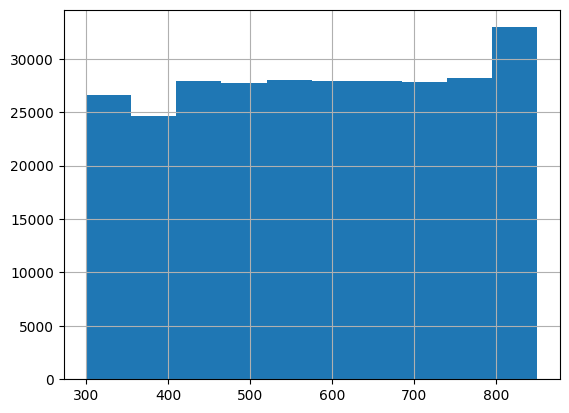

In [9]:
# Podemos ver la distribución de los score
credit['Credit Score'].hist();

In [10]:
# Definimos la variable score como la máscara ante el valor medio de score. De esta manera, exigimos a la clase target que esté balanceada
score = credit['Credit Score'].copy()
mean_score = score.mean()
score = score.apply(lambda x: 1 if x>=mean_score else 0)
score.value_counts()

1    140817
0    139039
Name: Credit Score, dtype: int64

In [11]:
# Definimos quienes serán la X y la y
X = credit.drop('Credit Score', axis=1)
y = score

In [12]:
# Vemos cuales son las variables numericas y cuales las categóricas
numericas = ['Age','Income','Credit History Length','Number of Existing Loans', 'Loan Amount', 'Loan Tenure','LTV Ratio','Profile Score']
categoricas = ['Gender', 'Existing Customer', 'State', 'City', 'Employment Profile', 'Occupation']

In [13]:
# Corroboramos que estén todos los features
len(numericas) + len(categoricas) == len(X.columns)

True

In [14]:
# Realizamos un escalado de las numericas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numericas])
X_scaled = pd.DataFrame(X_scaled, columns=X[numericas].columns)

In [15]:
# Revisamos si los valores numericos tienen un skew
X_scaled.skew().sort_values()

Profile Score              -1.014552
Loan Amount                -0.439019
LTV Ratio                  -0.180826
Age                        -0.002411
Credit History Length       0.009495
Number of Existing Loans    0.053826
Income                      0.708779
Loan Tenure                 0.842224
dtype: float64

In [16]:
# Vemos las variables categóricas
X[categoricas].head()

,Gender,Existing Customer,State,City,Employment Profile,Occupation
0,Male,No,Karnataka,Mysuru,Salaried,Doctor
1,Male,No,Karnataka,Bengaluru,Salaried,Software Engineer
2,Other,Yes,Uttar Pradesh,Kanpur,Salaried,Banker
3,Female,Yes,Karnataka,Bengaluru,Self-Employed,Contractor
4,Male,No,Karnataka,Mysuru,Salaried,Teacher


In [17]:
# Aplicamos un encoding para que tengan valores numericos
dummies = pd.get_dummies(X[categoricas])
dummies.head()

,Gender_Female,Gender_Male,Gender_Other,Existing Customer_No,Existing Customer_Yes,State_Delhi,State_Gujarat,State_Karnataka,State_Kerala,State_Maharashtra,...,Occupation_Farmer,Occupation_Graphic Designer,Occupation_Independent Consultant,Occupation_Other,Occupation_Photographer,Occupation_Shopkeeper,Occupation_Software Engineer,Occupation_Student,Occupation_Teacher,Occupation_Writer
0,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
# Chequeamos todas las columnas para ver cuál quitar
dummies.columns

Index(['Gender_Female', 'Gender_Male', 'Gender_Other', 'Existing Customer_No',
       'Existing Customer_Yes', 'State_Delhi', 'State_Gujarat',
       'State_Karnataka', 'State_Kerala', 'State_Maharashtra',
       'State_Rajasthan', 'State_Tamil Nadu', 'State_Telangana',
       'State_Uttar Pradesh', 'State_West Bengal', 'City_Ahmedabad',
       'City_Bengaluru', 'City_Bishanpura', 'City_Channarayapatna',
       'City_Chennai', 'City_Coimbatore', 'City_Dhulagori', 'City_Hyderabad',
       'City_Jaipur', 'City_Kanpur', 'City_Kochi', 'City_Kolkata',
       'City_Lucknow', 'City_Manjari', 'City_Mumbai', 'City_Mysuru',
       'City_Nagpur', 'City_Nellikuppam', 'City_New Delhi', 'City_Pune',
       'City_Surat', 'City_Thiruvananthapuram', 'City_Udaipur',
       'Employment Profile_Freelancer', 'Employment Profile_Salaried',
       'Employment Profile_Self-Employed', 'Employment Profile_Student',
       'Employment Profile_Unemployed', 'Occupation_Banker',
       'Occupation_Business Owner', 

In [20]:
# Eliminamos una columna de cada clase para que sean mutuamente excluyentes
X_cat = dummies.drop([
    'Gender_Other',
    'Existing Customer_No',
    'State_West Bengal',
    'City_Udaipur',
    'Employment Profile_Unemployed',
    'Occupation_Other'
], axis=1)

In [23]:
# Generamos el nuevo dataframe X con el scaled y el cat
X_new = pd.concat([X_scaled, X_cat], axis=1)

In [24]:
# Revisamos si las columnas son las correspondientes
X_new.columns

Index(['Age', 'Income', 'Credit History Length', 'Number of Existing Loans',
       'Loan Amount', 'Loan Tenure', 'LTV Ratio', 'Profile Score',
       'Gender_Female', 'Gender_Male', 'Existing Customer_Yes', 'State_Delhi',
       'State_Gujarat', 'State_Karnataka', 'State_Kerala', 'State_Maharashtra',
       'State_Rajasthan', 'State_Tamil Nadu', 'State_Telangana',
       'State_Uttar Pradesh', 'City_Ahmedabad', 'City_Bengaluru',
       'City_Bishanpura', 'City_Channarayapatna', 'City_Chennai',
       'City_Coimbatore', 'City_Dhulagori', 'City_Hyderabad', 'City_Jaipur',
       'City_Kanpur', 'City_Kochi', 'City_Kolkata', 'City_Lucknow',
       'City_Manjari', 'City_Mumbai', 'City_Mysuru', 'City_Nagpur',
       'City_Nellikuppam', 'City_New Delhi', 'City_Pune', 'City_Surat',
       'City_Thiruvananthapuram', 'Employment Profile_Freelancer',
       'Employment Profile_Salaried', 'Employment Profile_Self-Employed',
       'Employment Profile_Student', 'Occupation_Banker',
       'Occupati